<a href="https://colab.research.google.com/github/nikolagojakovic/diffusion_model/blob/main/diffusion_model_ipybn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In this notebook i tried to make a base model(not ideal)for generating images.

Sources:


*   Github Implementation:https://github.com/lucidrains/denoising-diffusion-pytorch

*   Niels Rogge, Kashif Rasul:https://colab.research.google.com/github/huggingface/notebooks/blob/main/examples/annotated_diffusion.ipynb#scrollTo=3a159023


*   Papers on Diffusion models ([Dhariwal, Nichol, 2021], [Ho et al., 2020] ect.)




# Dataset Investigation

As dataset i used CIFAR10 which really good for fast testing and seeing results,in this dataset pictures are really small(32x32) so i won't need further modifications :)


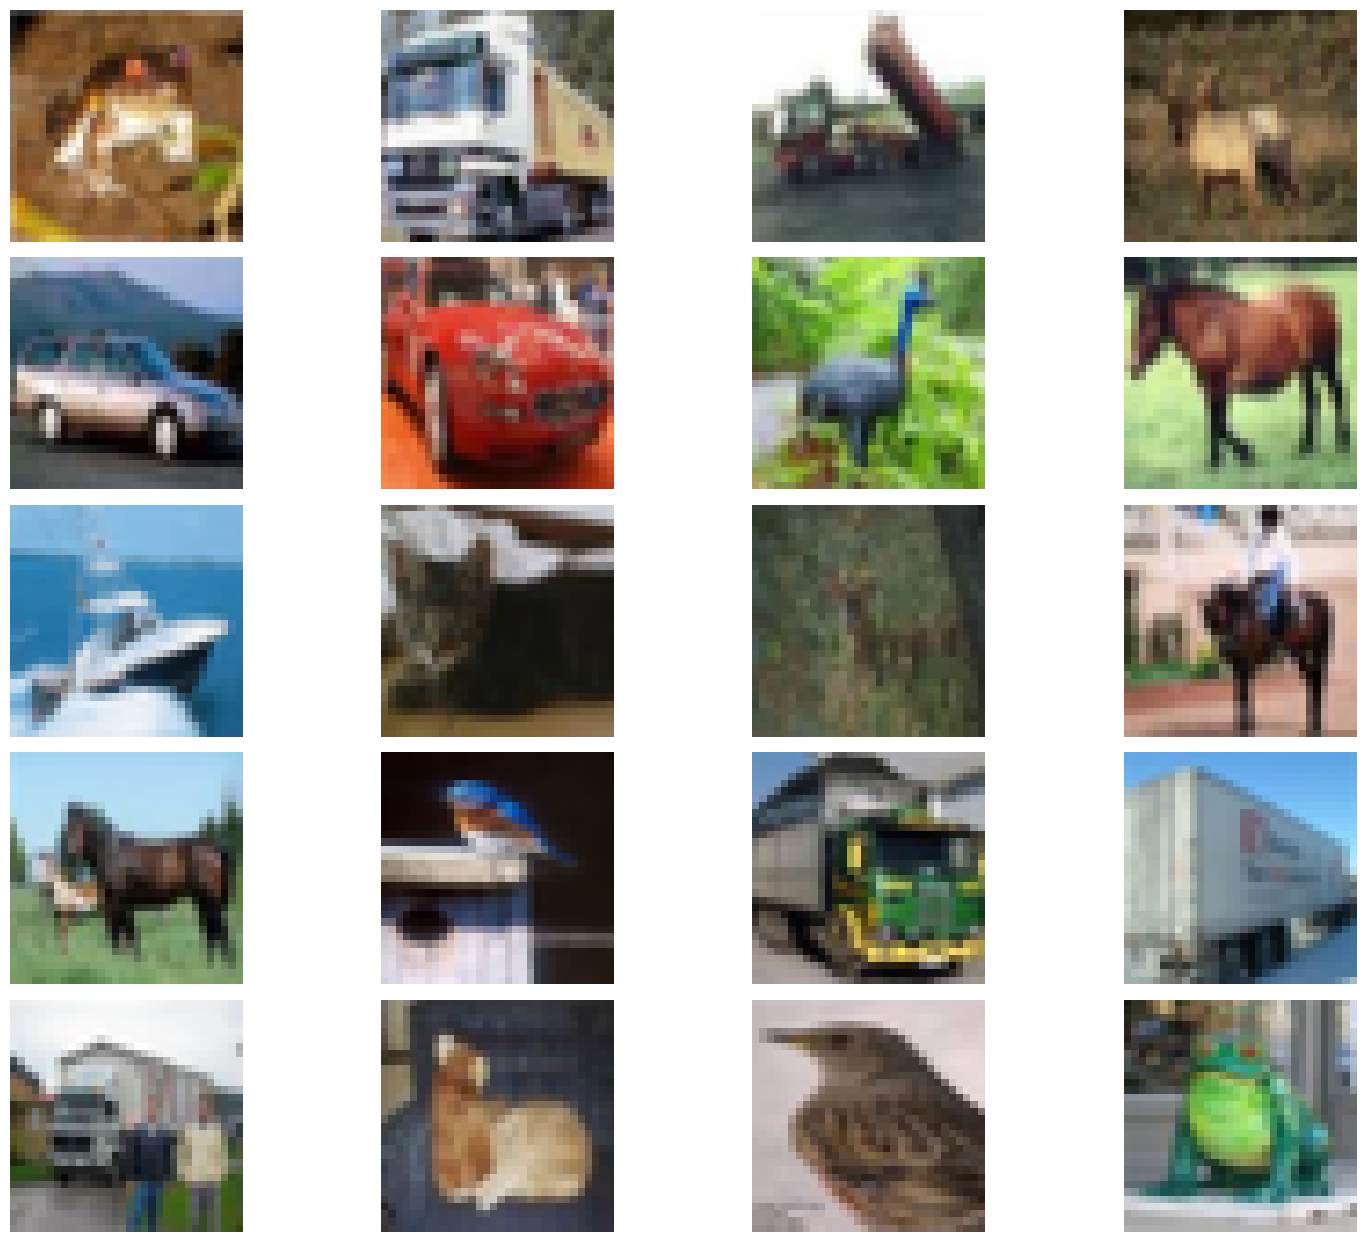

In [13]:
import torchvision
import matplotlib.pyplot as plt
from torchvision import transforms
from torchvision.datasets import CIFAR10

# Transform: only convert image to tensor, keep original pixel range [0, 1]
transform = transforms.ToTensor()

# Load CIFAR-10 dataset
data = CIFAR10(root=".", train=True, download=True, transform=transform)

# Function to display images from the dataset
def show_images(dataset, num_samples=20, cols=4):
    plt.figure(figsize=(15, 15))
    for i in range(num_samples):
        img, label = dataset[i]
        img = img.permute(1, 2, 0)  # Convert [C, H, W] to [H, W, C]
        plt.subplot(int(num_samples / cols) + 1, cols, i + 1)
        plt.imshow(img)
        plt.axis('off')
    plt.tight_layout()
    plt.show()

# Show the images
show_images(data)






# Building a Diffusion Model


Forward Process


In [14]:
import torch.nn.functional as F

def linear_beta_schedule(timesteps,start=0.0001, end=0.02):
    return torch.linspace(start,end,timesteps)

def get_index_from_list(vals,t,x_shape):
  batch_size=t.shape[0]
  out=vals.gather(-1,t.cpu())
  return out.reshape(batch_size,*((1,)*(len(x_shape)-1))).to(t.device)

def forward_diffusion_sample(x_0, t, device="cpu"):
    noise = torch.randn_like(x_0)
    sqrt_alphas_cumprod_t = get_index_from_list(sqrt_alphas_cumprod, t, x_0.shape)
    sqrt_one_minus_alphas_cumprod_t = get_index_from_list(sqrt_one_minus_alphas_cumprod, t, x_0.shape)

    return (
        sqrt_alphas_cumprod_t.to(device) * x_0.to(device) +
        sqrt_one_minus_alphas_cumprod_t.to(device) * noise.to(device),
        noise.to(device)
    )



# Define beta schedule
T = 300
betas = linear_beta_schedule(timesteps=T)

# Pre-calculate different terms for closed form
alphas = 1. - betas
alphas_cumprod = torch.cumprod(alphas, axis=0)
alphas_cumprod_prev = F.pad(alphas_cumprod[:-1], (1, 0), value=1.0)
sqrt_recip_alphas = torch.sqrt(1.0 / alphas)
sqrt_alphas_cumprod = torch.sqrt(alphas_cumprod)
sqrt_one_minus_alphas_cumprod = torch.sqrt(1. - alphas_cumprod)
posterior_variance = betas * (1. - alphas_cumprod_prev) / (1. - alphas_cumprod)


Testing in CIFAR10 dataset

In [15]:
import torchvision
from torchvision import transforms
from torch.utils.data import DataLoader
import numpy as np
import matplotlib.pyplot as plt
import torch  # Needed for dataset loading

IMG_SIZE = 64
BATCH_SIZE = 128

def load_transformed_dataset():
    # Fix 1: transforms.Resize takes size as a tuple, and interpolation mode is optional
    data_transforms = [
        transforms.Resize((IMG_SIZE, IMG_SIZE), interpolation=transforms.InterpolationMode.BILINEAR),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Lambda(lambda t: (t * 2) - 1)  # Scale to [-1, 1]
    ]
    data_transforms = transforms.Compose(data_transforms)

    # Fix 2: CIFAR10 does not support split='test', should use train=False
    train = torchvision.datasets.CIFAR10(root=".", train=True, download=True, transform=data_transforms)
    test = torchvision.datasets.CIFAR10(root=".", train=False, download=True, transform=data_transforms)

    return torch.utils.data.ConcatDataset([train, test])

def show_tensor_image(image):
    reverse_transforms = transforms.Compose([
        transforms.Lambda(lambda t: (t + 1) / 2),           # [-1, 1] → [0, 1]
        transforms.Lambda(lambda t: t.permute(1, 2, 0)),    # CHW → HWC
        transforms.Lambda(lambda t: t * 255),               # [0, 1] → [0, 255]
        transforms.Lambda(lambda t: t.numpy().astype(np.uint8)),  # Tensor → uint8 array
        transforms.ToPILImage(),                            # PIL Image for matplotlib
    ])

    if len(image.shape) == 4:
        image = image[0]  # Get the first image in the batch

    plt.imshow(reverse_transforms(image))
    plt.axis("off")
    plt.show()

# Load data
data = load_transformed_dataset()
dataloader = DataLoader(data, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)


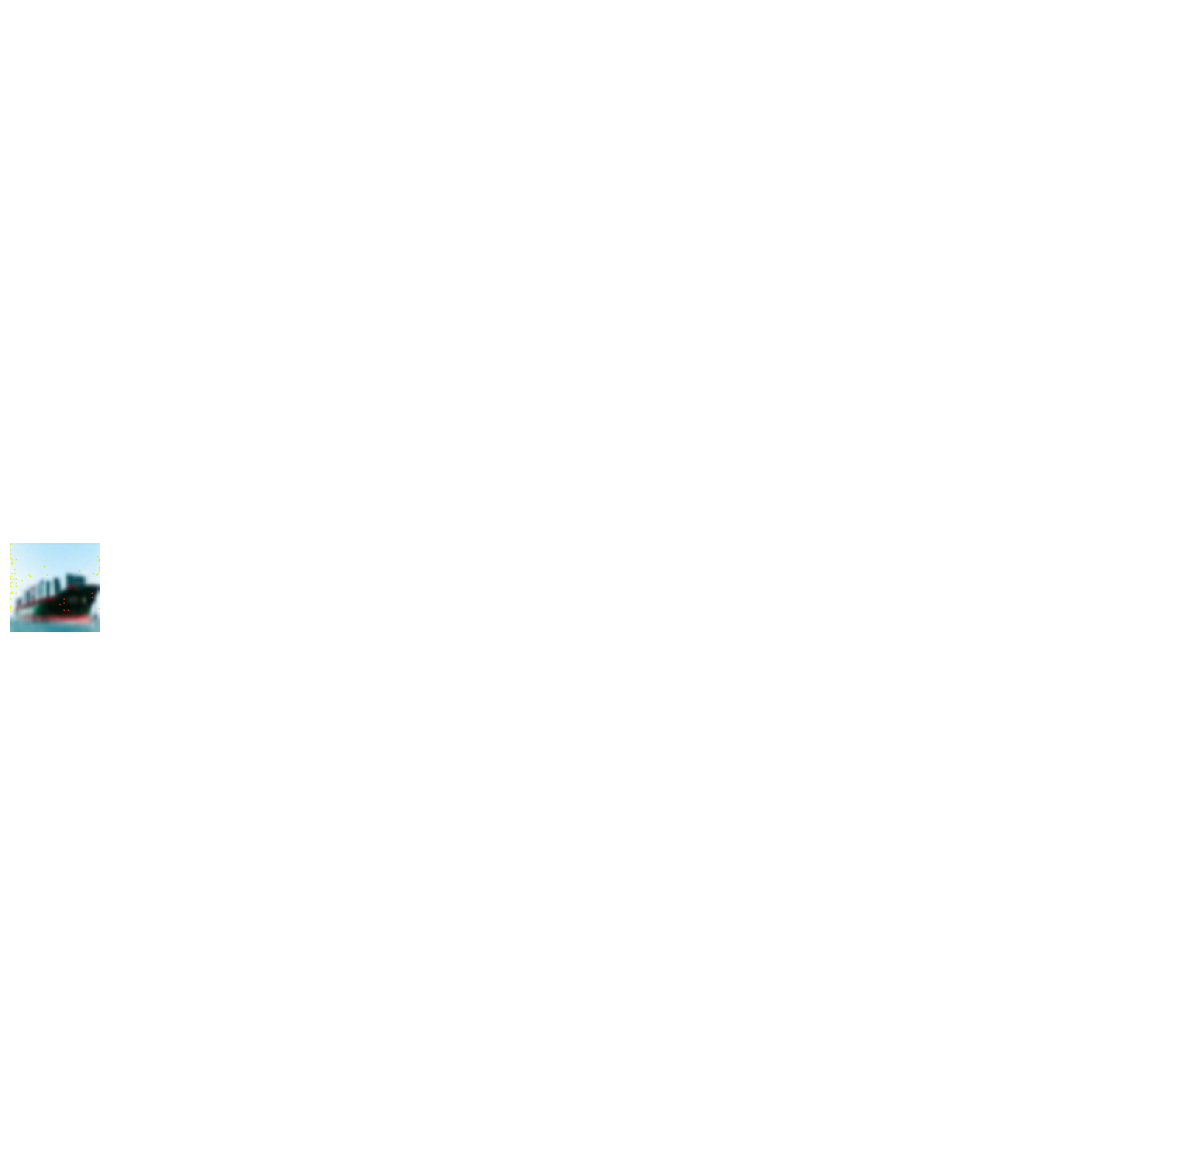

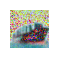

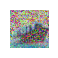

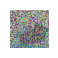

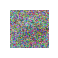

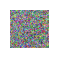

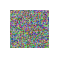

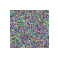

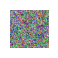

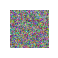

In [16]:
image=next(iter(dataloader))[0]

plt.figure(figsize=(15,15))
plt.axis('off')
num_img=10
stepsize=int(T/num_img)

for idx in range(0,T,stepsize):
  t=torch.Tensor([idx]).type(torch.int64)
  plt.subplot(1,num_img+1,int(idx/stepsize)+1)
  img,noise=forward_diffusion_sample(image,t)
  show_tensor_image(img)

The Backward process=U-net


inspired by:https://amaarora.github.io/posts/2020-09-13-unet.html

Key Takeaways:
- We use a simple form of a UNet for to predict the noise in the image
- The input is a noisy image, the ouput the noise in the image
- Because the parameters are shared accross time, we need to tell the network in which timestep we are
- The Timestep is encoded by the transformer Sinusoidal Embedding
- We output one single value (mean), because the variance is fixed



In [17]:
import torch
import torch.nn as nn
import math

# Time embedding class
class SinusoidalPositionEmbeddings(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.dim = dim

    def forward(self, time):
        device = time.device
        half_dim = self.dim // 2
        embeddings = math.log(10000) / (half_dim - 1)
        embeddings = torch.exp(torch.arange(half_dim, device=device) * -embeddings)
        embeddings = time[:, None] * embeddings[None, :]
        embeddings = torch.cat((embeddings.sin(), embeddings.cos()), dim=-1)
        return embeddings

# Basic block
class Block(nn.Module):
    def __init__(self, in_ch, out_ch, time_emb_dim, up=False):
        super().__init__()
        self.time_mlp = nn.Linear(time_emb_dim, out_ch)
        if up:
            self.conv1 = nn.Conv2d(2 * in_ch, out_ch, 3, padding=1)
            self.transform = nn.ConvTranspose2d(out_ch, out_ch, 4, 2, 1)
        else:
            self.conv1 = nn.Conv2d(in_ch, out_ch, 3, padding=1)
            self.transform = nn.Conv2d(out_ch, out_ch, 4, 2, 1)

        self.conv2 = nn.Conv2d(out_ch, out_ch, 3, padding=1)
        self.bnorm1 = nn.BatchNorm2d(out_ch)
        self.bnorm2 = nn.BatchNorm2d(out_ch)
        self.relu = nn.ReLU()

    def forward(self, x, t):
        h = self.bnorm1(self.relu(self.conv1(x)))
        time_emb = self.relu(self.time_mlp(t))[(..., ) + (None, ) * 2]
        h = h + time_emb
        h = self.bnorm2(self.relu(self.conv2(h)))
        return self.transform(h)

# UNet
class SimpleUnet(nn.Module):
    def __init__(self):
        super().__init__()
        image_channels = 3
        down_channels = (64, 128, 256)  # Reduced for CIFAR-10 (32x32)
        up_channels = (256, 128, 64)
        out_dim = 3
        time_emb_dim = 32

        self.time_mlp = nn.Sequential(
            SinusoidalPositionEmbeddings(time_emb_dim),
            nn.Linear(time_emb_dim, time_emb_dim),
            nn.ReLU()
        )

        self.conv0 = nn.Conv2d(image_channels, down_channels[0], 3, padding=1)
        self.downs = nn.ModuleList([
            Block(down_channels[i], down_channels[i + 1], time_emb_dim)
            for i in range(len(down_channels) - 1)
        ])
        self.ups = nn.ModuleList([
            Block(up_channels[i], up_channels[i + 1], time_emb_dim, up=True)
            for i in range(len(up_channels) - 1)
        ])
        self.output = nn.Conv2d(up_channels[-1], out_dim, 1)

    def forward(self, x, timestep):
        t = self.time_mlp(timestep)
        x = self.conv0(x)
        residual_inputs = []

        for down in self.downs:
            x = down(x, t)
            residual_inputs.append(x)

        for up in self.ups:
            residual_x = residual_inputs.pop()
            x = torch.cat((x, residual_x), dim=1)
            x = up(x, t)

        return self.output(x)

model = SimpleUnet()
print("Num params: ", sum(p.numel() for p in model.parameters()))

Num params:  3692003


*Loss*

- After some maths we end up with a very simple loss function
- There are other possible choices like L2 loss ect.

In [18]:
def get_loss(model, x_0, t):
    x_noisy, noise = forward_diffusion_sample(x_0, t, device)
    noise_pred = model(x_noisy, t)
    return F.l1_loss(noise, noise_pred)

Sampling
- Without adding @torch.no_grad() we quickly run out of memory, because pytorch tacks all the previous images for gradient calculation
- Because we pre-calculated the noise variances for the forward pass, we also have to use them when we sequentially perform the backward process



In [19]:
@torch.no_grad()
def sample_timestep(x, t):
    """
    Predicts noise using the model and returns the denoised image at time t.
    Adds noise again unless it's the last step.
    """
    betas_t = get_index_from_list(betas, t, x.shape)
    sqrt_one_minus_alphas_cumprod_t = get_index_from_list(sqrt_one_minus_alphas_cumprod, t, x.shape)
    sqrt_recip_alphas_t = get_index_from_list(sqrt_recip_alphas, t, x.shape)

    model_mean = sqrt_recip_alphas_t * (
        x - betas_t * model(x, t) / sqrt_one_minus_alphas_cumprod_t
    )
    posterior_variance_t = get_index_from_list(posterior_variance, t, x.shape)

    if t[0] == 0:
        return model_mean
    else:
        noise = torch.randn_like(x)
        return model_mean + torch.sqrt(posterior_variance_t) * noise


@torch.no_grad()
def sample_plot_image():
    """
    Generates one sample from pure noise using the reverse diffusion process.
    """
    img_size = 32  # CIFAR-10
    num_channels = 3
    img = torch.randn((1, num_channels, img_size, img_size), device=device)

    num_images = 6
    stepsize = T // num_images

    plt.figure(figsize=(12, 3))
    plt.axis('off')

    for i in reversed(range(T)):
        t = torch.full((1,), i, device=device, dtype=torch.long)
        img = sample_timestep(img, t)
        img = torch.clamp(img, -1, 1)

        if i % stepsize == 0:
            plt.subplot(1, num_images, i // stepsize + 1)
            show_tensor_image(img.cpu())

    plt.tight_layout()
    plt.show()


Training


In [20]:
from torch.optim import Adam

# Set device: use GPU if available
device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)

# Optimizer and training parameters
optimizer = Adam(model.parameters(), lr=0.001)
epochs = 100  # You can increase this for better results

for epoch in range(epochs):
    for step, batch in enumerate(dataloader):
        model.train()
        optimizer.zero_grad()

        # Get images from the batch and move to device
        x = batch[0].to(device)  # batch[0] contains images; batch[1] are labels (unused)

        # Sample random timesteps for each image in the batch
        t = torch.randint(0, T, (BATCH_SIZE,), device=device).long()

        # Compute loss (difference between true and predicted noise)
        loss = get_loss(model, x, t)
        loss.backward()
        optimizer.step()

        # Log and generate samples every few epochs
        if epoch % 5 == 0 and step == 0:
            print(f"Epoch {epoch} | Step {step:03d} | Loss: {loss.item():.4f}")
            model.eval()
            sample_plot_image()


KeyboardInterrupt: 